In [ ]:
%%bash

pip3 install -r requirements.txt

In [3]:
#Import Libraries
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

<hr>
<center><h1>Gus Tropea - Comprehensive Exam Artifact</h1></center>
<hr>

In our synthesis we showed that we could produce a good earth scale model for the homogeneous shallow water equations (SWE) \begin{equation}
	\begin{bmatrix}
		h\\
		hu\\
		hv\\
	\end{bmatrix}_{t}+\begin{bmatrix}
	uh\\
	hu^2+\frac{1}{2}gh^2\\
	uvh\\
\end{bmatrix}_{x}+\begin{bmatrix}
vh\\
uvh\\
hv^2+\frac{1}{2}gh^2\\
\end{bmatrix}_y=0
\end{equation} 
where $h(x,y,t)$ is the depth of a water column, $u(x,y,t)$ is velocity in the $x$-direction, and $v(x,y,t)$ is velocity in the $y$-direction. (Note that when solving on the cube sphere there is a fourth equation for velocity in $z$-direction.) However, the wave speed of the homogeneous solution was much faster then the speed of the Lamb waves detected from the Hunga Tonga-Hunga Ha’apai (HHTH) erruption.

## Incorperating Physical Source Terms

Amores et al. [[1]](#1) proposed using temperature as a way to scale the shallow water model. Lamb waves travel at the theoretical speed of sound 312 $\mathrm{ms}^{-1}$ assuming a nearly isothermal atmosphere [[4]](#4). The speed of sound is dependent on the temperature of air. Therefore, we can use this relationship as a way to scale each water column by incorporating it as a type of bathymetry. In the SWE bathymetry represents changes in flux relative to space, and so it acts as a forcing term
\begin{equation}
	\begin{bmatrix}
		h\\
		hu\\
		hv\\
	\end{bmatrix}_{t}+\begin{bmatrix}
	uh\\
	hu^2+\frac{1}{2}gh^2\\
	uvh\\
\end{bmatrix}_{x}+\begin{bmatrix}
vh\\
uvh\\
hv^2+\frac{1}{2}gh^2\\
\end{bmatrix}_y=\begin{bmatrix}
    0\\
    -ghb_{x}\\
    -ghb_{y}\\
\end{bmatrix}.
\end{equation}
If we assume that the temperature in the stratosphere is constant starting at the tropopause, this acts as the free surface. Here this was chosen to be 100 $\mathrm{hPa}$ ($H\approx 20$ $\mathrm{km}$). To find the bathymetry term that would appropriately scale each water column Amores et al. [[1]](#1) related the velocity of sound to the velocity of shallow water waves
\begin{equation}
\sqrt{gH}=\sqrt{\frac{\gamma R T(x,y)}{M}}
\end{equation}
to get a relative height in the troposphere below
\begin{equation}
b=\frac{\gamma R T(x,y)}{Mg}
\end{equation}
where $\gamma=1.4$ is the ratio of specific heat for air corresponding to the given range of atmospheric temperatures, $R=8314.36$ $\mathrm{J\cdot kmol}^{-1}\mathrm{K}^{-1}$ is the universal gas constant, $M=28.966$ $\mathrm{kg\cdot kmol}^{-1}$ is the molecular mass for dry air, and $T(x,y)$ $\mathrm{K}$ is absolute temperature.

In [4]:
def temp2bath(T):
    """
    Gus Tropea 9/4/24 - Function to calculate relative depth from a given temperature
    INPUTS:  T - a temperature in units of Kelvin.
    OUTPUTS: b - a bathymetry term in units of meters.
    """
    gamma = 1.4 # ratio of specific heat of air corresponding to the range of atmospheric temperatures    
    R = 8314.36 # j kmol^(-1) k^(-1) universal gas constant
    M = 28.966 # kg kmol^(−1) molecular mass for dry air
    g = 9.81 # m s^(-2)
    b = (gamma*R*T)/(M*g) #scaling bathymetry term to be returned
    return b 

## Modeling the Event

To incorperate these source terms into our model we need to collect global temperature data from the time of erruption up to a few days after. We will also need to be able to map this data to any point on the sphere as well as the cube sphere.

### Collecting the Data

The data used was sourced from ERA5 reanalysis. ERA5 uses physics based numerical models and observations to curate a best estimate of different atmospheric conditions around the globe. For this model we will use two data sets from ERAS. The first is temperature data from 2$\mathrm{m}$ above sea level [[5]](#5), and the second is temperature data from 100 $\mathrm{hPa}$ [[6]](#6).

<table style="float: left; padding-right: 50px;">
    <thead>
        <tr>
            <th><h3>Single Level(s) Dataset</h3></th>
        </tr>
        <tr>
            <th>Data Description</th>
            <th></th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td><strong>Data type:</strong></td>
        <td>Gridded</td>
      </tr>
    </tbody>
    <tr>
        <td><strong>Projection:</strong></td>
        <td>Lat/Lon</td>
    </tr>
    <tr>
        <td><strong>Horizontal Coverage:</strong></td>
        <td>Global</td>
    </tr>
    <tr>
        <td><strong>Horizontal Resolution:</strong></td>
        <td>Reanalysis: 0.25&deg; x 0.25&deg;<br/> Mean, spread and members: 0.5&deg; x 0.5&deg;</td>
    </tr>
        <tr>
        <td><strong>Temporal Coverage:</strong></td>
        <td>1940-Present</td>
    </tr>
    <tr>
        <td><strong>Temporal Resolution:</strong></td>
        <td>Hourly</td>
    </tr>
        <tr>
        <td><strong>File Format:</strong></td>
        <td>GRIB</td>
    </tr>
    <tr>
        <td><strong>Updated:</strong></td>
        <td>Daily</td>
    </tr>
        <tr>
        <td><strong>Link:</strong></td>
        <td><a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.adbb2d47?tab=overview">Official Link </a><br/><br/>
        <a href="https://drive.google.com/file/d/1eWOnu6W_618SFqTeIvlb9XTvXdlM3gC_/view?usp=drive_link">Google Drive</a>
        </td>
    </tr>
</table>
<table style="float: center; padding-left: 50px;">
    <thead>
        <tr>
            <th><h3>Pressure Level(s) Dataset</h3></th>
        </tr>
        <tr>
            <th>Data Description</th>
            <th></th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td><strong>Data type:</strong></td>
        <td>Gridded</td>
      </tr>
    </tbody>
    <tr>
        <td><strong>Projection:</strong></td>
        <td>Lat/Lon</td>
    </tr>
    <tr>
        <td><strong>Horizontal Coverage:</strong></td>
        <td>Global</td>
    </tr>
    <tr>
        <td><strong>Horizontal Resolution:</strong></td>
        <td>Reanalysis: 0.25&deg; x 0.25&deg;<br/> Mean, spread and members: 0.5&deg; x 0.5&deg;</td>
    </tr>
        <tr>
        <td><strong>Vertical Coverage:</strong></td>
        <td>1000 hPa to 1 hPa</td>
    </tr>
    <tr>
        <td><strong>Vertical Resolution:</strong></td>
        <td>37 Pressure Levels</td>
    </tr>
    <tr>
        <td><strong>Temporal Coverage:</strong></td>
        <td>1940-Present</td>
    </tr>
    <tr>
        <td><strong>Temporal Resolution:</strong></td>
        <td>Hourly</td>
    </tr>
        <tr>
        <td><strong>File Format:</strong></td>
        <td>GRIB</td>
    </tr>
    <tr>
        <td><strong>Updated:</strong></td>
        <td>Daily</td>
    </tr>
        <tr>
        <td><strong>Link:</strong></td>
        <td><a href="https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.bd0915c6?tab=overview">Official Linnk</a><br/><br/>
        <a href="https://drive.google.com/file/d/16NTS0YWKxzxs0HVBgCUGxW-oNx3JJrJq/view?usp=drive_link">Google Drive</a>
        </td>
    </tr>
</table>

### Processing the Data

#### The xarray package

The xarray package adds labels on top of multidimensional numpy arrays. For example these labels can be coordinates, units, or other data attributes and function similar to data-frames. This allows for more intuitive and easy to read code. The xarray package also has many useful built in functions, such as dimension specific mathematical operations, and simplified plotting utilizing the labeled data. Using other geoscience specific python packages such as eccode, pygrib, and cfgrib we can read in the ERA5 data and store it in a numpy array while maintaining the associated labels.

In [7]:
# Read the ERA5 data into a labeled numpy array 

ds2m = xr.load_dataset("data/2m.grib", engine="cfgrib") #Load the 2m data set using xarray
ds100hpa = xr.load_dataset("data/100hPa.grib", engine="cfgrib") #Load the 100hPa dataset using xarray

In [8]:
#Useful for ploting later
mintemp = np.floor(int(ds100hpa.t.min())) #Calculate the minimum observed temperature
maxtemp = np.ceil(int(ds2m.t2m.max())) #Calculate the maximum observed temperature


We have collected data that spans the five day period of 15 January 2022, 00:00 $\mathrm{UTC}$ through 20 January 2022, 23:59 $\mathrm{UTC}$. However, we want to trim this to only take into acount the time of eruption and five days after (15 January 2022, 04:00 $\mathrm{UTC}$ through 20 January 2022, 04:00 $\mathrm{UTC}$).

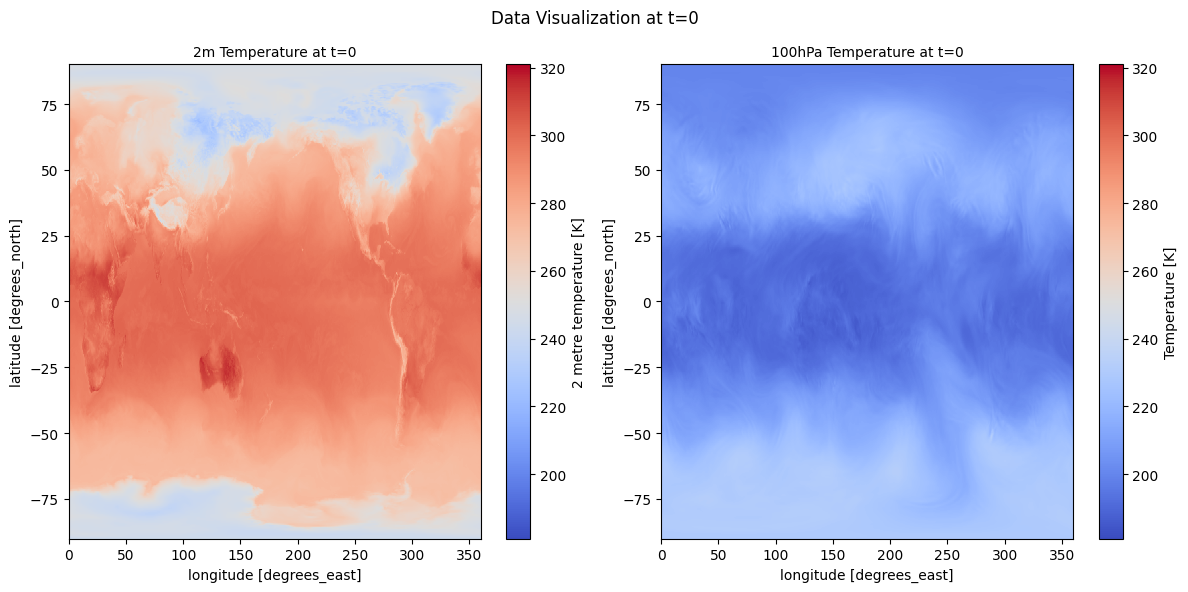

In [10]:
#Calculate the time window
t0 = 5; #time start as an index value of the time dimension
tend = (t0+(5*24))-1; #time end as an index value of the time dimension

#Slice the data sets
ds2m = ds2m.isel(time=slice(t0,tend))
ds100hpa = ds100hpa.isel(time=slice(t0,tend))

#Visualize the data
fig = plt.figure(figsize=(12, 6), tight_layout=True) #Set up a figure for subploting
fig.suptitle('Data Visualization at t=0',fontsize='large') #Set the main figure title

#Plot the first figure - 2m data at time zero
ax = fig.add_subplot(121) #Add the plot to the figure
sp2m=ds2m.t2m[0].plot(cmap=plt.cm.coolwarm) #Use the xarray plot funciton
ax.set_title('2m Temperature at t=0',fontsize='medium') #Set the plot title
sp2m.set_clim(mintemp,maxtemp) #Set the colorbar limits

#Plot the second figure - 100hPa data at time zero
ax = fig.add_subplot(122) #Add the plot to the figure
sp100hpa=ds100hpa.t[0].plot(cmap=plt.cm.coolwarm, clim=(0,322)) #Use the xarray plot funciton
ax.set_title('100hPa Temperature at t=0',fontsize='medium') #Set the plot title
sp100hpa.set_clim(mintemp,maxtemp) #Set the colorbar limits


To calculate the bathymetry terms we will need to find the vertical average value of these two temperatures.


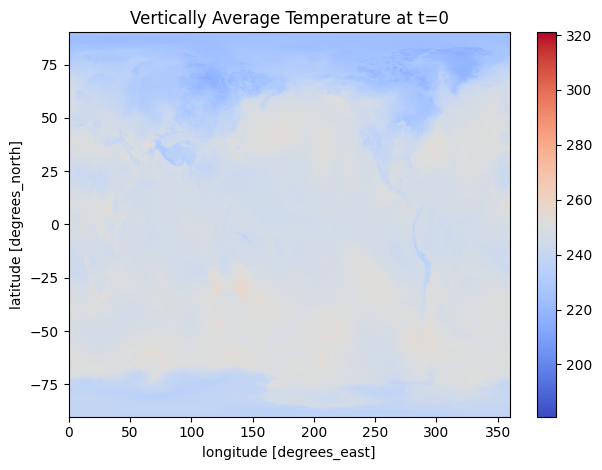

In [11]:
#Calculate the vertical average of the dataset
dsavg = (ds2m.t2m+ds100hpa.t)/2

#Visualize the dat#a
fig, ax = plt.subplots(tight_layout=True)

#Plot the vertically averaged data at time zero
pavg = dsavg[0].plot(cmap=plt.cm.coolwarm) #Use the xarray plot function
ax.set_title('Vertically Average Temperature at t=0',fontsize='large') # Set the plot title
pavg.set_clim(mintemp,maxtemp) #Set the colorbar limits

To simplify things we will assume that bathymetry doesn't change with time. We will calculate the average temperature over the five day period of 15 January 2022, 04:00 $\mathrm{UTC}$ through 20 January 2022, 04:00 $\mathrm{UTC}$ for each water column to get an overall temperature profile.

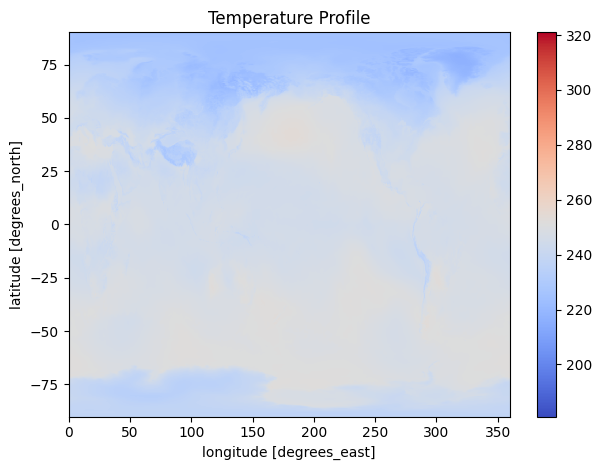

In [14]:
#Find the average temperature over the time dimension 
temps = dsavg.mean(dim="time")

#Visualize the dat#a
fig, ax = plt.subplots(tight_layout=True) #Set up a figure for plotting

ptemps = temps.plot(cmap=plt.cm.coolwarm) #Use the xarray plot function
ax.set_title('Temperature Profile',fontsize='large') #Set the plot title
ptemps.set_clim(mintemp,maxtemp) #Set colorbar limits

From this we can calculate a bathymetry profile to scale our shallow water model. 

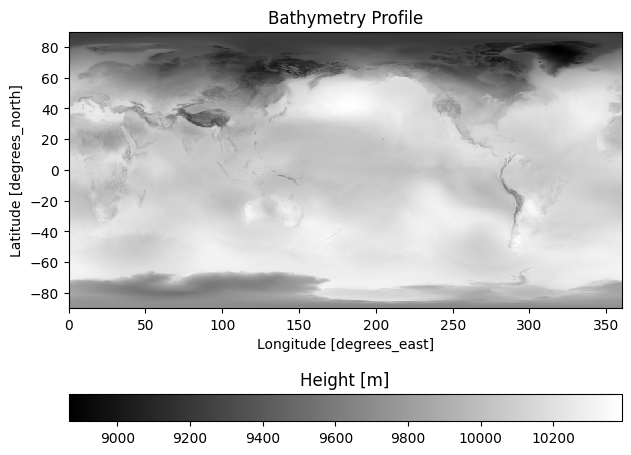

In [32]:
#Calculate the bathymetry terms
tempsnp = temps.as_numpy() #convert xarray dataset to a numpy array
bathymetry = np.vectorize(temp2bath)(tempsnp) #vectorize function for fast math

#Visualize the data
fig, ax = plt.subplots(tight_layout=True) #Set up a figure for plotting
img = ax.imshow(bathymetry, interpolation='none', cmap=plt.cm.gray, extent=[0,360,-90,90]) #Plot bathymetry in degrees north and degrees east
cbar = fig.colorbar(img, orientation="horizontal", pad=0.2) #Create a colorbar

ax.set_xlabel("Longitude [degrees_east]") #Set x-axis label
ax.set_ylabel("Latitude [degrees_north]") #Set y-axis label

ax.set_title("Bathymetry Profile") #Set plot title
cbar.ax.set_title("Height [m]"); #Set colorbar title

## Bathymetry in ForestClaw

Since the bathymetry data is only available for a very coarse grid, we can output the data to a relatively small binary file. This makes it easy for us to use this computed bathymetry data with other programs.

In [33]:
#Open the file
file = open("data/bathymetry_grid.dat", "wb")

#Write numpy array to a file
bathymetry.tofile(file)

#Close the file
file.close()

Since ForestClaw uses needs bathymetry data at points not available in ERA5 dataset, we need to be able to interpolate the given data. An example of how we read in the data and get the interpolated values of bathymetry in forestclaw is shown below in the following C program.

In [41]:
%%file c_code/bathymetry_interp.c

#include <stdlib.h>
#include <stdio.h>
#include <math.h>


//Global Variables
//==================================================================
#define nlat 721  // number of rows in data file
#define nlon 1440  // number of columns in data file

static int dataread = 1; // set to 0 once data has been readin
static double bathymetry[nlat][nlon]; //bathymetry data array
static double nbrs[4][4]; //Keep track of the known points
                                //[upper left[lat, lon, I-idx, J-idx],
                                // upper right[lat, lon, I-idx, J-idx],
                                // lower left[lat, lon, I-idx, J-idx],
                                // lower right[lat, lon, I-idx, J-idx]]
const double eps = 1.0e-15; //epsilon value
const double dv = 0.25; //grid spacing in text file

//==================================================================


//Methods and Functions
//==================================================================

void readData(){
    //Gus Tropea 9/17/24 - Method to read in data file
    //INPUTS:   None
    //OUTPUTS:  None

    FILE *bfp;
    bfp = fopen("data/bathymetry_grid.dat", "r");
    //If the file could not be read print error and exit
    if (bfp == NULL){
        printf("readdata (bathymetry_interp) : File handle is NULL\n");
        exit(0);
    }
    //Read the data in to the bathymetry array
    for (int i = 0; i < nlat; i++){
        for (int j = 0; j < nlon; j++){
            fread(&bathymetry[i][j],sizeof(double),1,bfp);
        }
    }
    fclose(bfp);
}
    

//Find the four closest known grid points
void getNeighbors(double lat, double lon){
    //Gus Tropea 9/17/24 - Method to find the four closest know grid points and store the data.
    //Values are in ranges of lat=[-90,90] and lon=[0,360]
    //INPUTS:   lat - type double for a value of latitude
    //          lon - type double for a value of a longitude
    //OUTPUTS:  None

    double left;
    double right;
    double upper;
    double lower;
    int upperidx;
    int loweridx;
    int leftidx;
    int rightidx;

    //Find closest points of latitude

    //Check lower latitude boundary and wrap
    if(lat < -89.75){
        lower = -90;
        upper = lat+dv;
    }
    //Check upper latitude boundary and wrap
    else if( lat > 89.75){
        lower = lat-dv;
        upper = -90;
    }
    else{
        lower = floor(lat / dv) * dv;
        upper = ceil(lat / dv) * dv;
    }

    //Find closest points of longitude

    //Check left longitude boundary and wrap
    if(lon < 0.25){
        left = 0;
        right = lon+dv;
    }
    //check right longitude boundary and wrap
    else if( lon > 359.75){
        left = lon-dv;
        right = 0;
    }
    else{
        left = floor(lon / dv) * dv;
        right = ceil(lon / dv) * dv;
    }
    
    //Find the array index for the closest points of latitude and longitude
    upperidx = floor((upper + 90)/dv);
    loweridx = floor((lower + 90)/dv);
    leftidx = floor(left/dv);
    rightidx = floor(right/dv);

    //Set the neighbor array values
    nbrs[0][0] = upper;
    nbrs[0][1] = left;
    nbrs[0][2] = (double) upperidx;
    nbrs[0][3] = (double) leftidx;
    nbrs[1][0] = upper;
    nbrs[1][1] = right;
    nbrs[1][2] = (double) upperidx;
    nbrs[1][3] = (double) rightidx;
    nbrs[2][0] = lower;
    nbrs[2][1] = left;
    nbrs[2][2] = (double) loweridx;
    nbrs[2][3] = (double) leftidx;
    nbrs[3][0] = lower;
    nbrs[3][1] = right;
    nbrs[3][2] = (double) loweridx;
    nbrs[3][3] = (double) rightidx;
}


double bathymetry_interp(double *lat_ptr, double *lon_ptr){
    //Gus Tropea 9/17/24 - Function to calculate the scaling bathymetry term for any given latitude and longitude based on climate data
    //INPUTS:   lat_ptr - pointer to a type double value of a given latitude
    //          lon_ptr - Pointer to a type double value of a given longitude
    //OUTPUTS:  depth - type double value of a bathymetry term

    double lat = *lat_ptr; //dereference pointer
    double lon  = *lon_ptr; //dereference pointer
    double depth = 0;

    //Check to see if the file has already been read
    if(dataread == 1){
        readData();
        dataread = 0;
    }

    //Check to see if exact value is known
    double checklat = fmod(lat, dv);
    double checklon = fmod(lon, dv);
    //known latitude and longitude return the bathymetry term
    if((checklat < eps) && (checklon < eps)){
        double fixedlat = floor(lat / dv) * dv;
        double fixedlon = floor(lon / dv) * dv;
        int latidx = floor((fixedlat + 90)/dv);
        int lonidx = floor(fixedlon/dv);
        depth = bathymetry[latidx][lonidx];
        return depth;
    }

    //known latitude average over the line of longitude and return bathymetry term
    else if(checklat < eps){
        double fixedlat = floor(lat / dv) * dv;
        double lon1 = floor(lon / dv) * dv;
        double lon2 = ceil(lon / dv) * dv;
        int latidx = floor((fixedlat + 90)/dv);
        int lon1idx = floor(lon1/dv);
        int lon2idx = floor(lon2/dv);
        depth = (bathymetry[latidx][lon1idx] + bathymetry[latidx][lon2idx]) / 2;
        return depth;
    }

    //known longitude average over the line of latitude and return bathymetry term
    else if(checklon < eps){
        double fixedlon = floor(lon / dv) * dv;
        double lat1 = floor(lat / dv) * dv;
        double lat2 = ceil(lat / dv) * dv;
        int lonidx = floor(fixedlon/dv);
        int lat1idx = floor(lat1+90/dv);
        int lat2idx = floor(lat2+90/dv);
        depth = (bathymetry[lat1idx][lonidx] + bathymetry[lat2idx][lonidx]) / 2;
        return depth;
    }

    //No know values 
    else{
        //Find known data
        getNeighbors(lat,lon);
    
        //Get relative height at known points
        double f11 = bathymetry[(int) nbrs[2][2]][(int) nbrs[2][3]]; //lower left
        double f12 = bathymetry[(int) nbrs[0][2]][(int) nbrs[0][3]];  //upper left
        double f21 = bathymetry[(int) nbrs[3][2]][(int) nbrs[3][3]];  //lower right
        double f22 = bathymetry[(int) nbrs[1][2]][(int) nbrs[1][3]];  //upper right

        //90 degrees (same lat different lon):
        //Exact value at this latitude is known. Take the average value at the closest two longitudes.
        if(nbrs[0][2] == nbrs[3][2]){
            return (f11+f21)/2;
        }
  
        //90 degrees (same lon different lat): 
        //Exact value at this longitude is known. Take the average value at the closest two latitudes.
        else if (nbrs[0][3] == nbrs[2][3]){
            return (f11+f12)/2;
        }

        //No known points
        //Bilinear interpolate
        else{
            double x1 = nbrs[2][1]; //lower left longitude
            double x2 = nbrs[3][1]; //lower right longitude
            double y1 = nbrs[2][0]; //lower left latitude
            double y2 = nbrs[0][0]; //upper left latitude

            double u = f11*((x2-lon)/(x2-x1)) + f21*((lon-x1)/(x2-x1));
            double v = f12*((x2-lon)/(x2-x1)) + f22*((lon-x1)/(x2-x1));
            depth = u*((y2-lat)/(y2-y1)) + v*((lat-y1)/(y2-y1));

            return depth;
        }
    }
}
//==================================================================

Overwriting c_code/bathymetry_interp.c


Below is C program that demostrates how the bathymetry C program might be used in ForestClaw.

In [50]:
%%file c_code/main.c


#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>
#include "bathymetry_interp.c"

//Global Variables
//==================================================================
#define minlat -90  // minimum latitude
#define maxlat 90  // maximum latitude
#define minlon 0  // minimum longitude
#define maxlon 360 // maximum longitude

int nplat; //number of points in the y-direction
int nplon; //number of points in the x-direction
double dy; //step size in the y-direction
double dx; //step size in the x-direction
FILE* fout = NULL;

//=================================================================

// Methods and Functions
//=================================================================

int main(int argc, char* argv[]){
  //Gus Tropea 9/17/24 - Function main program
  //INPUTS: argc - expects 2 inputs
  //        argv - number of points of latitude and number of points of longitude i.e. "720 1440"
  //OUTPUTS: binary file of bathymetry terms

  //Check to see if there are enough arguements given         
  if(argc < 3){
    printf("%s \n","Too few arguments");
    exit(0);
  }
  else{
    //time the program
    clock_t tic = clock();
    
    //read in inputs
    nplat = atoi(argv[1]);
    nplon = atoi(argv[2]);
    
    //calculate step size
    dy = fabs(maxlat-minlat)/nplat;
    dx = fabs(maxlon-minlon)/nplon;

    printf("==============================================================\n");
    printf("Desired Grid Resolution: \n");
    printf("--------------------------------------------------------------\n");
    printf("Degrees of Latitude: %f,\tDegrees of Longitude: %f\n",dy,dx);
    printf("--------------------------------------------------------------\n");
    printf("\t Calculating bathymetry terms, and writing to a file...\n");

    //Open the file
    FILE *fout = fopen("data/demo_bathymetry.dat","wb");

    //Write the grid size to the file
    fwrite(&nplat,sizeof(int),1,fout);    
    fwrite(&nplon,sizeof(int),1,fout);

    //Write the bathymetry data to the file
    for(int i=0;i<nplat;i++){
      for(int j=0;j<nplon;j++){
        double y = minlat+(dy*i);
        double x = minlon+(dx*j);
        double b = bathymetry_interp(&y,&x);
        fwrite(&b,sizeof(double),1,fout);
      }
    }

    //Close the file
    fclose(fout);

    //Stop the clock
    clock_t toc = clock();

    printf("\t Elapsed Time: %f seconds\n", (double)(toc - tic) / CLOCKS_PER_SEC);
    printf("==============================================================\n");
  }
  return 0;
}

Overwriting c_code/main.c


Now we can compile and run the C code

In [51]:
%%bash

gcc c_code/main.c -o main -lm
./main 720 1440

Desired Grid Resolution: 
--------------------------------------------------------------
Degrees of Latitude: 0.250000,	Degrees of Longitude: 0.250000
--------------------------------------------------------------
	 Calculating bathymetry terms, and writing to a file...
	 Elapsed Time: 0.076390 seconds


The results of the main C program are shown below

Points of Latitude: 720
Points of Longitude: 1440
Actual File size   : 8294408 bytes (7.91 MB)
Expected file size : 8294408 bytes (7.91 MB)


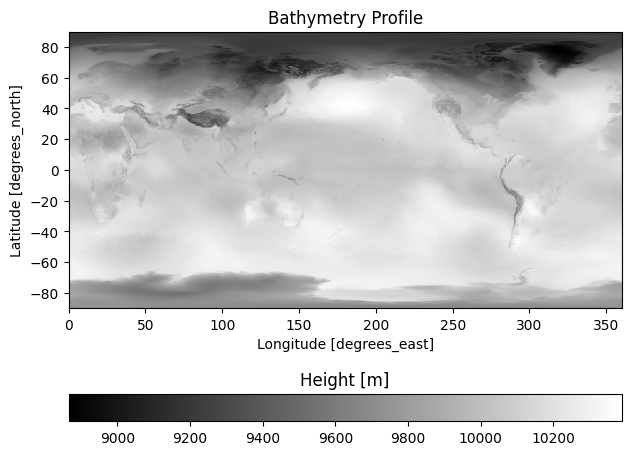

In [57]:
#Read bathymetry dimensions from binary file resulting from the c code
path = "data/demo_bathymetry.dat" #The file path
file = open(path,"rb") #Read the file

N, = np.fromfile(file,dtype=np.int32,count=1) #Read the number of points of latitude
M, = np.fromfile(file,dtype=np.int32,count=1) #Read the number of points of longitude

file.close() #Close the file

print("Points of Latitude: "+str(N)) #Print the number of points of latitude
print("Points of Longitude: "+str(M)) #Print the number of points of longitude

#Check that the file size is what we expect it to be
stats = os.stat(path) #Get the actual file size
print(f"Actual File size   : {stats.st_size:d} bytes ({(stats.st_size/1024)/1024:.2f} MB)") #Print the actual file size

esize = 4+4+(8*(N*M)) #Calculated the expected file size based off of the dimensions and data types (INT+INT*(DOUBLE*(N*M))

print(f"Expected file size : {esize:d} bytes ({(esize/1024)/1024:.2f} MB)") #Print the expected file size

#Define the numpy datatypes for reading in the entire binary file
#Number of points of latitude type=INT
#Number of points of longitude type=INT
#Bathymetry data type=DOUBLE number of doubles to read is N*M
dt = np.dtype([('N',np.int32), \
            ('M',np.int32), \
            ('q',np.float64,N*M)]) 

#Read bathymetry dimensions from binary file resulting from the c code
file = open(path,"rb") #Open the file
N,M,b = np.fromfile(file,dtype=dt, count=1)[0] #Read in the data from the file and assign it to the variables using the previously defined data types 
file.close #Close the file

#Reshape the array with bathymetry data
u = np.reshape(b,(N,M)) #Creates a 2d array of shape (N,M)

#Visualize the data
fig, ax = plt.subplots(tight_layout=True) #Set up a figure for plotting
img = ax.imshow(u, interpolation='none', cmap=plt.cm.gray, extent=[0,360,-90,90]) #Plot bathymetry in degrees north and degrees east
cbar = fig.colorbar(img, orientation="horizontal", pad=0.2) #Create a colorbar

ax.set_xlabel("Longitude [degrees_east]") #Set x-axis label
ax.set_ylabel("Latitude [degrees_north]") #Set y-axis label

ax.set_title("Bathymetry Profile") #Set plot title
cbar.ax.set_title("Height [m]"); #Set colorbar title

## Visualizing bathymetry on the cube sphere in ForestClaw

Given the *bathymetry_interp* program demostrated previously, we can use the bathymetry grid data file to visualize what the bathymetry profile would look like on the cube sphere in ForestClaw.

![bathymetry profile on the cube sphere](images/bathymetry_cube_sphere.png "Bathymetry on the Cube Sphere")

We using a similar process we can create a data grid file for temperature and visualize that on the cube sphere in ForestClaw as well.

![temperature profile on the cube sphere](images/temperature_cube_sphere.png "Temperature on the Cube Sphere")


To get an idea of how this will impact the accuracy of the shallow water model, we can take the average of the bathymetry profile to get a constant $H=(\eta-b)$, and test it with our homogenious solver. These results are shown below.

![bathymetry wave position](images/bathwavepos.png "Bathymetry Wave Position")
![bathymetry wave velocity](images/bathwavevelocity.png "Bathymetry Wave Velocity")
![bathymetry wave arrival](images/avgbath.png "Bathymetry Wave Arrives at Half Way Point")

We find that this wave arrives at the half way point at around 9.1 hours. Corresponding to a velocity of 309.2 $\mathrm{ms}^{-1}$, Very close to the theoretical speed of lamb waves.

## References
<hr>

1. <a class="anchor" name="1"></a>Angel Amores, Sebastian Monserrat, Marta Marcos, Daniel Argüeso, Joan Vil-
lalonga, Gabriel Jordà, and Damià Gomis. Numerical simulation of atmospheric
Lamb waves generated by the 2022 Hunga-Tonga volcanic eruption. Geophysical
Research Letters, 49(6):e2022GL098240, 2022.

2. <a class="anchor" name="2"></a>Carsten Burstedde, Lucas C. Wilcox, and Omar Ghattas. p4est: Scalable
Algorithms for Parallel Adaptive Mesh Refinement on Forests of Octrees. SIAM
Journal on Scientific Computing, 33(3):1103–1133, 2011.

3. <a class="anchor" name="3"></a>Donna Calhoun and Carsten Burstedde. ForestClaw: A parallel algorithm for
patch-based adaptive mesh refinement on a forest of quadtrees. arXiv preprint
arXiv:1703.03116, 2017.

3. <a class="anchor" name="4"></a>FP Bretherton. Lamb waves in a nearly isothermal atmosphere. Quarterly
Journal of the Royal Meteorological Society, 95(406):754–757, 1969.

5. <a class="anchor" name="5"></a>Hans Hersbach, Bill Bell, Paul Berrisford, Gionata Biavati, András Horányi,
Joaquı́n Muñoz Sabater, Julien Nicolas, Carole Peubey, Raluca Radu, Iryna
Rozum, et al. ERA5 hourly data on single levels from 1979 to present. Copernicus
climate change service (c3s) climate data store (cds), 10(10.24381), 2018.

7. <a class="anchor" name="6"></a>Hans Hersbach, Bill Bell, Paul Berrisford, Gionata Biavati, András Horányi,
Joaquı́n Muñoz Sabater, Julien Nicolas, Carole Peubey, Raluca Radu, Iryna
Rozum, et al. ERA5 hourly data on pressure levels from 1979 to present. Copernicus
climate change service (c3s) climate data store (cds), 10(10.24381), 2018.